### imports

In [1]:
import lmdb
import numpy as np
import pickle
import matplotlib.pyplot as plt
import PIL.ImageOps
from PIL import Image
from sklearn.model_selection import StratifiedKFold

import env
from utils import KaggleCameraDataset, progress_iter

%matplotlib inline
%load_ext autoreload
%autoreload 2

## load training data

In [3]:
train_data = KaggleCameraDataset('../data/', train=True)
additional_train_data = KaggleCameraDataset('../data/additional-train/', train=True)
additional_val_data = KaggleCameraDataset('../data/additional-val/', train=True)

## calculate dataset size

In [4]:
crop_size = 1024
n_crops = 1
N = len(train_data) + len(additional_train_data) + len(additional_val_data)
size = crop_size**2*3*n_crops*N
print N
print size
print "Dataset will occupy {0:.2f} GB".format(size/float(2**30))

15097
47491055616
Dataset will occupy 44.23 GB


In [6]:
X = np.zeros((N, 256, 256, 3), dtype=np.uint8)
print X.nbytes

540672000


## #1 gen data (center crops only)

In [16]:
X = np.zeros((N, crop_size, crop_size, 3), dtype=np.uint8)

pos = 0
for x, _ in progress_iter(train_data, verbose=True):
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                w/2+crop_size/2, h/2+crop_size/2))
    
    X[pos, ...] = np.asarray(x, dtype=np.uint8)
    pos += 1
    
y = np.asarray(train_data.y)

A Jupyter Widget

## #1.1 save to lmdb

In [10]:
map_size = size + N * 1024 * 64
map_size

48480452608

In [11]:
env = lmdb.open('../data/train.lmdb', map_size=map_size)

## original data
index = 0
for x, y in progress_iter(train_data, verbose=True):
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                w/2+crop_size/2, h/2+crop_size/2))

    str_id = '{:06}'.format(index)
    with env.begin(write=True) as txn:
        txn.put(str_id, x.tobytes())

    index += 1
    
## additional train data
additional_train_ind = []
for x, y in progress_iter(additional_train_data, verbose=True):
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                w/2+crop_size/2, h/2+crop_size/2))

    str_id = '{:06}'.format(index)
    with env.begin(write=True) as txn:
        txn.put(str_id, x.tobytes())

    additional_train_ind.append(index)
    index += 1

## additional val data
additional_val_ind = []
for x, y in progress_iter(additional_val_data, verbose=True):
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                w/2+crop_size/2, h/2+crop_size/2))

    str_id = '{:06}'.format(index)
    with env.begin(write=True) as txn:
        txn.put(str_id, x.tobytes())
    
    additional_val_ind.append(index)
    index += 1

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [12]:
env.stat()

{'branch_pages': 1L,
 'depth': 2L,
 'entries': 15097L,
 'leaf_pages': 90L,
 'overflow_pages': 11602937L,
 'psize': 4096L}

### check

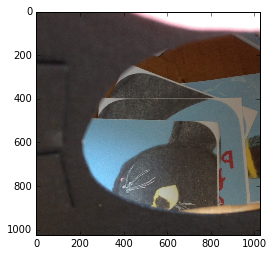

In [14]:
env = lmdb.open('../data/train.lmdb', readonly=True)
index = 13377
with env.begin() as txn:
    bytes = txn.get('{:06}'.format(index))
    x = Image.frombytes('RGB', (1024, 1024), bytes)
    plt.imshow(x)

In [16]:
np.save('../data/additional_train_ind.npy', np.asarray(additional_train_ind))
np.save('../data/additional_val_ind.npy', np.asarray(additional_val_ind))
y = np.asarray(train_data.y + additional_train_data.y + additional_val_data.y)
np.save('../data/y_train.npy', y)

## #2 gen aug data (center crops + D4 group)

In [4]:
X = np.zeros((N * 8, crop_size, crop_size, 3), dtype=np.uint8)

pos = 0
for x, _ in progress_iter(train_data, verbose=True):
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                w/2+crop_size/2, h/2+crop_size/2))
    
    X[pos, ...] = np.asarray(x, dtype=np.uint8)
    pos += 1
    X[pos, ...] = np.asarray(x.transpose(Image.ROTATE_90), dtype=np.uint8)
    pos += 1
    X[pos, ...] = np.asarray(x.transpose(Image.ROTATE_180), dtype=np.uint8)
    pos += 1
    X[pos, ...] = np.asarray(x.transpose(Image.ROTATE_270), dtype=np.uint8)
    pos += 1
    
    x = PIL.ImageOps.mirror(x)
    
    X[pos, ...] = np.asarray(x, dtype=np.uint8)
    pos += 1
    X[pos, ...] = np.asarray(x.transpose(Image.ROTATE_90), dtype=np.uint8)
    pos += 1
    X[pos, ...] = np.asarray(x.transpose(Image.ROTATE_180), dtype=np.uint8)
    pos += 1
    X[pos, ...] = np.asarray(x.transpose(Image.ROTATE_270), dtype=np.uint8)
    pos += 1

y = np.asarray(train_data.y).repeat(8)

A Jupyter Widget

## split into folds

In [100]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
z = np.asarray([0, 1]).repeat(5)
fold = 3
for i, (train_ind, test_ind) in enumerate(skf.split(z, z)):
    if i == fold:
        print train_ind, test_ind

# new_ind = np.concatenate( [test_ind for _, test_ind in skf.split(z, z)] )
# print new_ind

[1 2 3 4 6 7 8 9] [0 5]


In [18]:
new_ind = np.concatenate( [test_ind for _, test_ind in skf.split(y, y)] )
print new_ind.shape

(2750,)


In [19]:
X = X[new_ind]
y = y[new_ind]

### reshape for easy extraction of train, val

In [20]:
X = X.reshape(len(X)/5, 5, 256, 256, 3).transpose((1, 0, 2, 3, 4))
X.shape

(5, 550, 256, 256, 3)

In [21]:
y = y.reshape(len(y)/5, 5).T
y.shape

(5, 550)

### save

In [22]:
np.save('../data/X_folds.npy', X)
np.save('../data/y_folds.npy', y)